In [2]:
import numpy as np
import glob
import os
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc
import MFCC_computation as util

reload(util)

%matplotlib inline

## Fabien vs Henrik

Here we compare Fabien Salathe and Henrik Akesson's vowels.

In [4]:
path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'fab' : glob.glob(path + '/fab*.wav'),
    'hen': glob.glob(path + '/hen*.wav')
}

# number of coefficients used
MFCC_COEFFS = 13

### MFCC Visualization

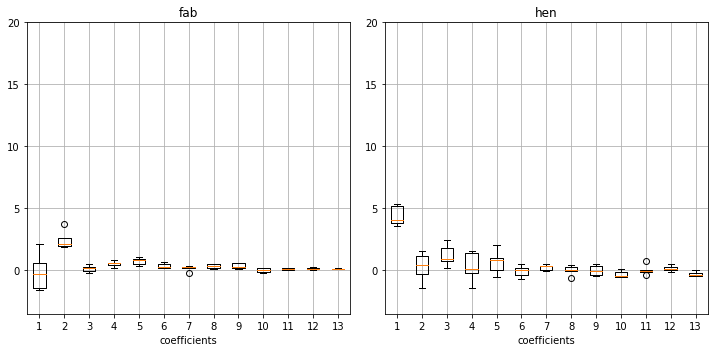

In [5]:
util.print_coeff_boxplot(['fab', 'hen'], FILES)

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

testing 8 neurons...
testing 32 neurons...
testing 64 neurons...
Done


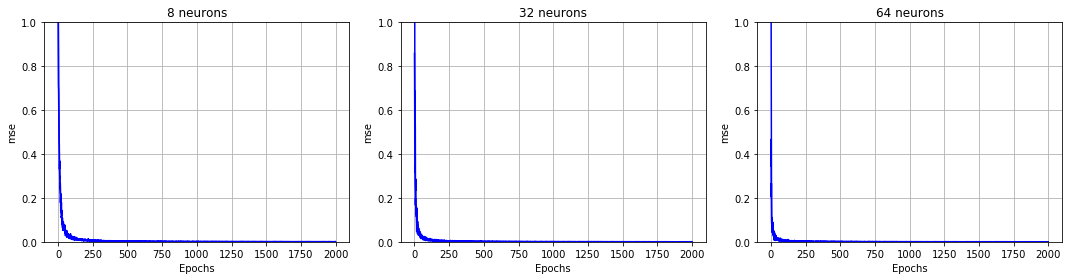

In [6]:
EPOCHS = 2000
N_NEURONS = [8, 32, 64]
LEARNING_RATE = 0.001
MOMENTUM = 0.7

K = 3
##

N_INITS = 2
dataset = util.create_dataset([('fab', -1), ('hen', 1)], FILES)
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'tanh')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

util.print_mse(MSE, N_NEURONS)
print 'Done'

Testing 8 neurons...
Testing 32 neurons...
Testing 64 neurons...


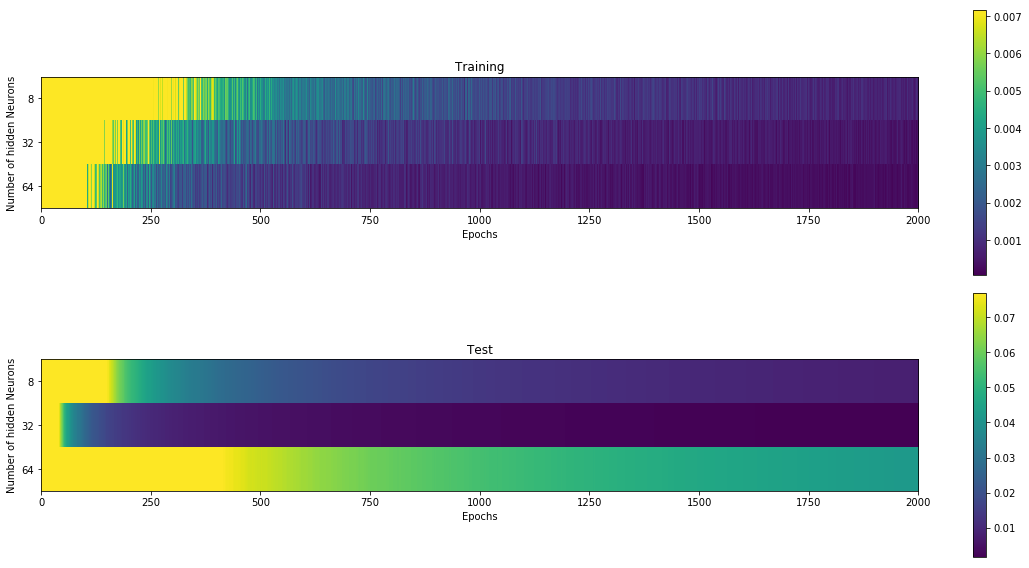

In [7]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))


dataset = util.create_dataset([('fab', -1), ('hen', 1)], FILES)

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2


# print results
util.print_mse_train_test(MSE_train, MSE_test, N_NEURONS, aspect=100)

### Final Model and performance

In [8]:
EPOCHS = 2000
N_NEURONS = 64
LEARNING_RATE = 0.0005
MOMENTUM = 0.7
K = 3

precision:	1.0
recall:	1.0
f1_score:	1.0
MSE training:	0.000609564722458
MSE test:	0.02786066031
Confusion matrix:
[[ 5.  0.]
 [ 0.  5.]]


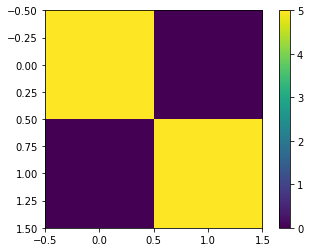

In [9]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=K,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)


precision, recall, f1_score = util.conf_mat_stats(conf_mat)
print "precision:\t", np.round(precision, 3)
print "recall:\t",    np.round(recall, 3)
print "f1_score:\t",  np.round(f1_score, 3)
print 'MSE training:\t', MSE_train
print 'MSE test:\t', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

| Parameter | Value |
| --- | --- |
| Number of epochs | 2000 |
|Number of neurons|64|
|Learning rate|0.0005|
|Momentum|0.7|

With these parameters the results are rather good, with a precision of 0.859.